In [1]:
import cv2
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def get_brisk():
    brisk = cv2.BRISK_create()
    kp1, desc1 = brisk.detectAndCompute(img1, None)
    kp2, desc2 = brisk.detectAndCompute(img2, None)
    return kp1, desc1, kp2, desc2

In [3]:
def brisk_bf_matcher(matches_number):
    kp1, desc1, kp2, desc2 = get_brisk()
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = matcher.match(desc1, desc2)
    matches = sorted(matches, key=lambda x: x.distance)

    return cv2.drawMatches(img1, kp1, img2, kp2, matches[:matches_number], None, flags=2)

In [4]:
def brisk_custom_matcher(matches_number=10):
    kp1, desc1, kp2, desc2 = get_brisk()

    matches = []
    for i, d1 in enumerate(desc1, start=0):
        for j, d2 in enumerate(desc2, start=0):
            matches.append(cv2.DMatch(_trainIdx=j, _queryIdx=i, _distance=float(np.sum(d1 ^ d2)), _imgIdx=0))

    matches = sorted(matches, key=lambda sample: sample.distance)

    return cv2.drawMatches(img1, kp1, img2, kp2, matches[:matches_number], None, flags=2)

In [5]:
def ransac(matches, kp1, kp2, iterations=2000, threshold=5):
    best_inlines = []
    for _ in range(iterations):
        samples = random.sample(matches, 4)
        src_pts = np.array([kp1[sample.queryIdx].pt for sample in samples]).reshape(-1, 1, 2)
        dst_pts = np.array([kp2[sample.trainIdx].pt for sample in samples]).reshape(-1, 1, 2)
        M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, threshold)

        if M is None:
            continue

        inlines = []
        for sample in matches:
            src_pt = np.array(kp1[sample.queryIdx].pt).reshape(-1, 1, 2)
            dst_pt = np.array(kp2[sample.trainIdx].pt).reshape(-1, 1, 2)
            transformed_pt = cv2.perspectiveTransform(src_pt, M)
            dist = np.linalg.norm(dst_pt - transformed_pt)
            if dist < threshold:
                inlines.append(sample)

        if len(inlines) > len(best_inlines):
            best_inlines = inlines

    return best_inlines

In [6]:
def brisk_ransac_matcher(matches_number):
    kp1, desc1, kp2, desc2 = get_brisk()

    matcher = cv2.BFMatcher()
    matches = matcher.match(desc1, desc2)

    inlines = ransac(matches, kp1, kp2)

    return cv2.drawMatches(img1, kp1, img2, kp2, inlines[:matches_number], None, flags=2)

In [7]:
def visualize(image):
    plt.figure(figsize=(12, 12))
    plt.imshow(image)

In [8]:
def display_variants():
    visualize(image=brisk_bf_matcher(matches_number=15))
    visualize(image=brisk_custom_matcher(matches_number=15))
    visualize(image=brisk_ransac_matcher(matches_number=15))

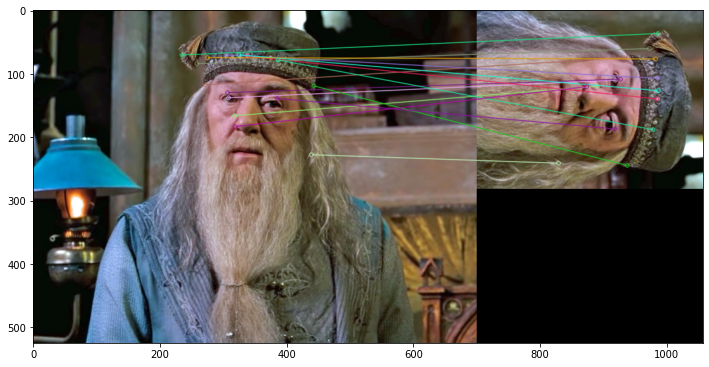

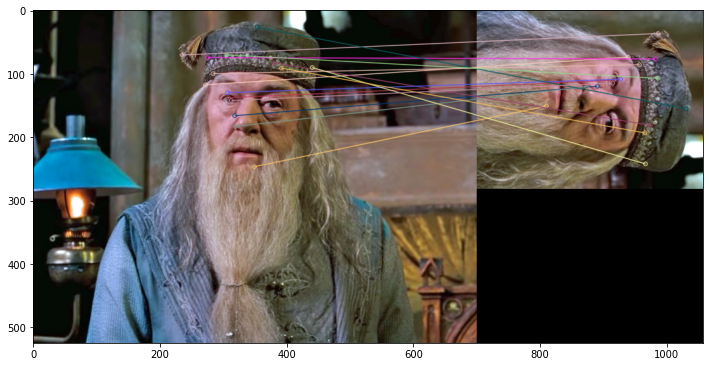

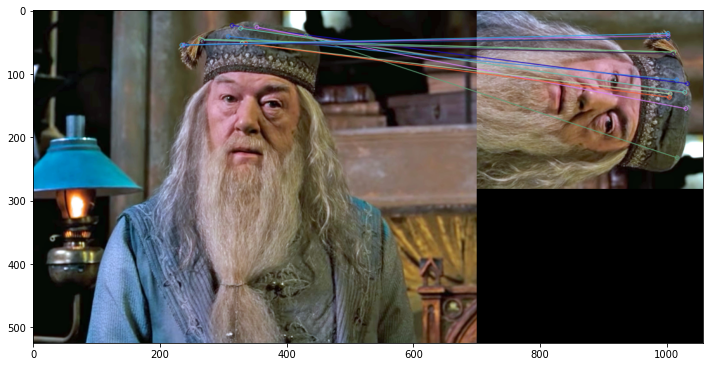

In [9]:
img1 = cv2.cvtColor(cv2.imread('img1.png', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('img2.png', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
display_variants()

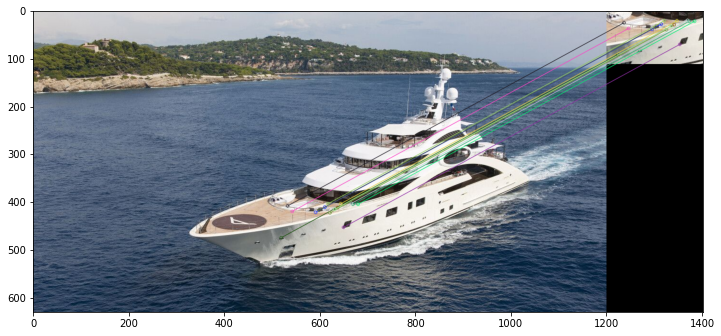

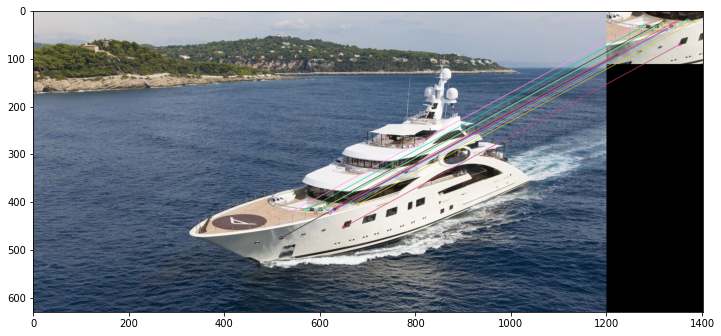

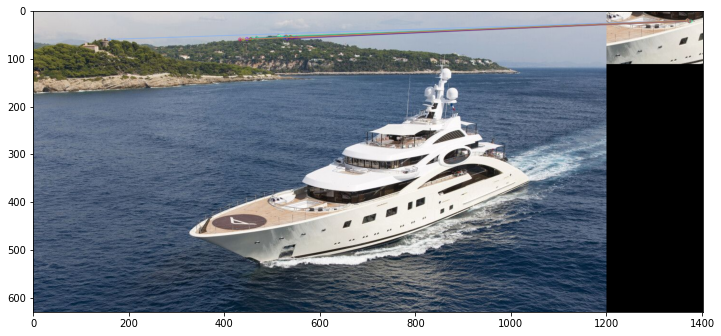

In [11]:
img1 = cv2.cvtColor(cv2.imread('img3.jpg', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('img4.jpg', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
display_variants()